# CSCG for counterfactual causal reasoning through episodic memories
Based on https://www.nature.com/articles/s41467-021-22559-5

**Clone the repo from github, Install the necessary libraries**

In [1]:
import sys, os
if not os.path.exists('naturecomm_cscg'):
  print("Cloning naturecomm_cscg repo from github.com/vicariousinc")
  os.system("git clone http://github.com/vicariousinc/naturecomm_cscg")

!pip install cairocffi
!pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.2 MB/s eta 0:00:00a 0:00:01


***Import the needed python modules***

In [51]:
sys.path.append('naturecomm_cscg')
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room, forwardE_mp, backtraceE, backtrace, forward_mp, rargmax, forwardE, backtraceE
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import tools

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

np.random.seed(52)

transition_matrix = np.array([   # lines transitions from columns transitions to...
    [0.0, 0.5, 0.0, 0.0, 0.5],   # 0, Station to Lunch or Train2
    [0.0, 0.0, 0.9, 0.0, 0.1],   # 1, Lunch to Train1
    [0.8, 0.0, 0.0, 0.2, 0.0], # 2, Train1 to Start or Airport
    [1.0, 0.0, 0.0, 0.0, 0.0],   # 3, Aiport to Start
    [0.1, 0.0, 0.0, 0.9, 0.0],   # 4, Train2 to Start or Airport
])

seq_length = 10000
seq_state_t0 = 0
pseudocount = 1e-4

n_clones = np.array(
    [1, 1, 2, 1], # define number of clones per state
    dtype = np.int64)

n_iter = 500

#### Generate sequence

In [52]:
seq = tools.generate_markov_seq(transition_matrix, seq_state_t0, seq_length)

# We want the algorithm to figure out the different train contexts by itself, thus we give them the same identity.
seq[seq == 4] = 2

# we create dummy action
a = np.zeros(seq_length, dtype=np.int64)

#### Train CSCG

In [53]:
# Generate data and train a CSCG.
chmm = CHMM(
    n_clones=n_clones,
    pseudocount=pseudocount,
    x=seq, a=a,
    seed=44)

progression = chmm.learn_em_T(seq, a, n_iter=n_iter)



Average number of clones: 1.25


  2%|▊                                     | 11/500 [00:00<00:04, 111.19it/s, train_bps=0.534]


#### Apply Viterbi pruning

In [57]:
chmm.learn_viterbi_T(seq, a, n_iter=100)

  2%|▊                                       | 2/100 [00:00<00:04, 23.64it/s, train_bps=0.539]


[0.56402665, 0.5391493, 0.5391493]

In [58]:
seq[:20]

array([0, 2, 0, 1, 2, 0, 2, 0, 2, 3, 0, 2, 3, 0, 1, 2, 0, 2, 3, 0])

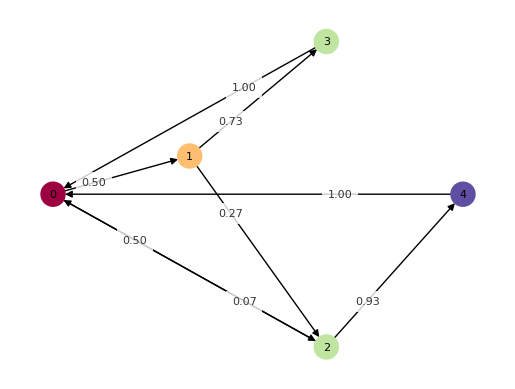

In [59]:
pos = [
    [0, 0.,],
    [1, .025,],
    [2, -.1],
    [2, .1],
    [3, 0.,],
]


kwargs_nxdraw = {
    'node_size': 300,
    'font_size': 8,
    'arrows': True,
#    'connectionstyle': 'arc,rad=0.4'
}

kwargs_fig = {
    'figsize': [4, 4],
}

kwargs_nxdrawedgelabel = {
    'font_size': 8,
    'label_pos': 0.7,  # Position along edge (0=start, 1=end)
    'bbox': dict(alpha=0.8, facecolor="white", edgecolor="none"),
    'rotate': False,
    'font_color': "#333333",
}

fig, ax = tools.plot_graph(
    chmm, seq, a, output_file="figures/test.pdf",
    pos=pos,
    kwargs_fig=kwargs_fig,
    kwargs_nxdraw=kwargs_nxdraw,
    kwargs_nxdrawedgelabel=kwargs_nxdrawedgelabel,
)


In [71]:
#note have another scenario that does not fulfil the criteria

In [70]:
# e means miss the plane
# c means going to lunch

# validate theorem i)
e_given_c = 0.73+.27*0.07
e_given_c
not_e_given_c = 0.27*0.93

print(e_given_c)
print(not_e_given_c)

# validate the#note have another scenario that does not fulfil the criteriaorem ii)
not_e_given_not_c = 0.93
e_given_not_c = 0.07

print(not_e_given_not_c)
print(e_given_not_c)

# fulfils inequality
# shows that going to lunch was the cause for missing the plane

0.7489
0.25110000000000005
0.93
0.07
